## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [3]:
#пропущенные значения - их нет
X.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [4]:
X.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

__Вывод__ В данных нет пропущенных значений и нет категориальных данных, все признаки являются вещественными

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [16]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y) # random_state=42

__Ответ:__ параметр stratify необходим для соблюдения баланса классов. Например, если в обучающей выборке большинство объектов имеют определенный класс, то модель некорректно будет предсказывать ответы на новых данных. Самый яркий пример: когда в обучающей выборке нет объектов с каким-то классов, а в тестовой есть. Тогда модель, необученная по этому классу, не сможет его предсказать.

Также, если посмотреть в теорию математической статистики, то, когда генеральная совокупность стратифицирована, чтобы выборка была репрезентативной, она должна сохранять пропорции между классами по признаку, чтобы не было смещенности в сторону какого-либо класса. stratify определяет пропорции между классами в переданном параметре (y) и сохраняет их в y_train и y_test. То есть можно считать, что train датасет репрезентативен и поэтому мы можем на нем обучать модель (то есть не будет смещения)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [18]:
X_train_scale = pd.DataFrame(data = X_train_scale, columns = X_train.columns)
X_train_scale.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.982686,-0.527640,0.173598,-1.087543,-0.727661,0.491455,0.791460,-0.596717,0.354587,0.255419,0.857462,0.437825,1.863180
1,0.957937,-0.745511,1.255504,0.839386,0.063252,1.131923,1.306553,-0.596717,1.343233,0.297587,1.032095,0.159563,1.749108
2,0.401078,-0.612894,1.777803,-1.235769,0.656436,0.491455,0.707363,-0.170491,-0.425924,-0.166255,0.595512,0.262081,0.429136
3,0.772317,-0.593949,-0.012937,-0.168547,0.392799,0.907759,1.243480,-1.193434,0.597412,0.803596,0.595512,0.408534,2.498722
4,-1.863482,0.107025,0.210905,0.098259,-0.266295,0.971806,0.822996,-0.340981,0.389276,-0.735516,-0.670576,1.155447,-0.401958


In [19]:
X_test_scale = pd.DataFrame(data = X_test_scale, columns = X_test.columns)
X_test_scale.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.252582,0.069135,1.143582,-0.316772,0.063252,0.811689,1.296041,-0.511472,2.089053,0.289153,0.333563,0.833249,1.423189
1,-0.972507,-0.792874,0.621283,-0.198192,0.260980,-0.645374,-0.270263,0.767208,-0.998298,-0.862018,2.167209,-0.543413,-1.281940
2,1.527171,-0.660257,0.434748,-0.939318,0.524618,1.612273,2.021376,-0.340981,0.441310,1.562610,1.206727,0.320662,3.036488
3,1.366300,-0.129790,0.919740,-0.613222,1.381440,0.491455,0.528657,-0.426226,-0.616715,0.023498,0.464538,1.433709,1.781700
4,0.141211,-0.745511,-0.982921,-1.235769,-0.134476,0.171222,0.665315,-0.681962,-0.408579,-0.545762,0.988436,0.130273,0.885422


In [20]:
X_train_reduced = X_train_scale[['alcohol', 'magnesium']]
X_test_reduced = X_test_scale[['alcohol', 'magnesium']]

In [11]:
from sklearn.metrics import mean_squared_error

In [21]:
k_n = np.array([1, 3, 5, 10, 15, 25])
train_column = []
test_column = []
clf_lst = []
for k in k_n:
  clf = KNeighborsClassifier(n_neighbors=k, p = 2)
  clf.fit(X_train_reduced, y_train)
  clf_lst.append(clf)
  y_predicted = clf.predict(X_train_reduced)
  train_column.append(mean_squared_error(y_train, y_predicted))
  y_predicted = clf.predict(X_test_reduced)
  test_column.append(mean_squared_error(y_test, y_predicted))

In [22]:
df = pd.DataFrame({'NN': k_n,
              'Train': train_column,
              'Test': test_column})
df.set_index('NN')

,Train,Test
NN,,
1,0.000000,1.388889
3,0.637097,1.037037
5,0.604839,0.981481
10,0.685484,1.129630
15,0.741935,1.259259
25,0.717742,1.037037


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [23]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [24]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

In [27]:
import warnings
warnings.filterwarnings("ignore")

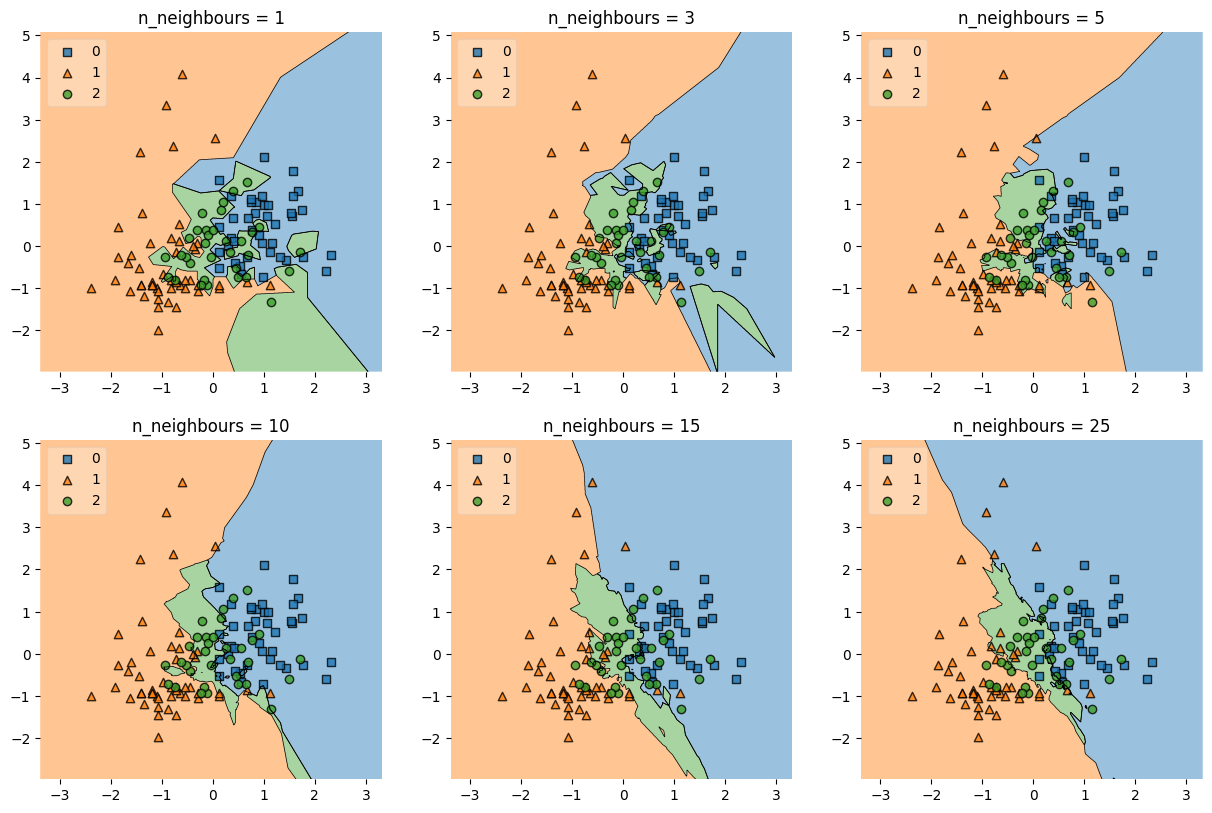

In [30]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(3, 3)

fig = plt.figure(figsize=(15,15))

labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']
for clf, lab, grd in zip(clf_lst, labels, list(itertools.product([0, 1, 2], repeat=2))[:6]):
  ax = plt.subplot(gs[grd[0], grd[1]])
  fig = plot_decision_regions(X=X_train_reduced.to_numpy(), y=y_train, clf=clf, legend=2)
  plt.title(lab)

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Число соседей, при которых ошибка на тестовой выборке минимальная = 5. По решающей поверхности видно, что если выбирать меньше, то модель переобучается - старается подстроиться под обучающую выборку и поэтому возникает много отдаленных зеленых кластеров (например, отдаленных зеленый кластер в синей области - логичнее было бы сказать, что так как вокруг много синих, то объект тоже должен относиться к синему классу). Если брать k больше 5, то многие скопления зеленых объектов начинают подавляться другими объектами и поэтому не воспринимаются моделью как значимые - отсюда много ошибок при определении класса обхектов, котороые исходно относятся к зеленым.

Самое очевидное переобучение показано на решающей поверхности с k=1. На ней видно, что абсолютно каждая точка выделена кластером своего цвета, то есть модель не приобрела никакой обобщающей способности

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

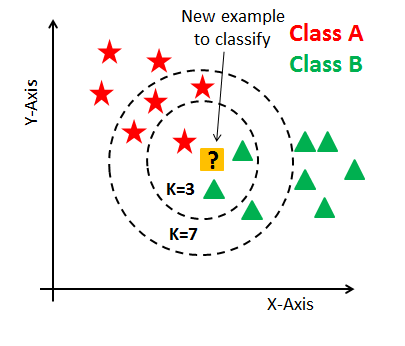

__Ссылка на код из цикла__ https://stackoverflow.com/questions/52823555/get-every-value-with-maximum-count-in-a-numpy-array

In [31]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      self.X = X
      self.target = y


    def predict(self, X):
      X_new =  X[:, np.newaxis, :]
      distances = self.count_distance(X_new, self.X)
      indexes = np.argsort(distances, axis = 1)[:, :self.k]
      y_current = self.target[indexes]
      y_pred = []
      for row in y_current:
        unique_values, cnt = np.unique(row, return_counts = True)
        value = unique_values[cnt == cnt.max()]
        y_pred.append(value[0])
      return np.array(y_pred)

    def count_distance(self, x, y):
      distances = np.sum((x - y)**2, axis = -1)
      return distances

In [32]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [33]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [34]:
import os

In [45]:
data = pd.read_csv(os.path.abspath('diamonds.csv'))
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [46]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [47]:
#Количество нулей в столбце x
print(data[data['x'] == 0]['x'].count())
#Количество нулей в столбце y
print(data[data['y'] == 0]['y'].count())
#Количество нулей в столбце z
print(data[data['z'] == 0]['z'].count())
#в качестве примера
data[data['x'] == 0]

8
7
20


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
11182,11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.0,6.62,0.0
11963,11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.0,0.00,0.0
15951,15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.0,0.00,0.0
24520,24521,1.56,Ideal,G,VS2,62.2,54.0,12800,0.0,0.00,0.0
26243,26244,1.20,Premium,D,VVS1,62.1,59.0,15686,0.0,0.00,0.0
27429,27430,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.00,0.0
49556,49557,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.00,0.0
49557,49558,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.00,0.0


__Вывод:__
* Значений NaN в датасете нет, однако отсутствие информации могло обозначаться другими символами. Например, не может быть, чтобы бриллиант карата 1.00 имел размеры 0x0x0. Поэтому нулевые значения в столбцах x, y, z могут обозначать пропуски (код для удаления нулевых значений закомментирован далее в ячейках).
* Бессмысленный столбец - unnamed: 0

In [48]:
#data['x'] = data['x'].replace(0, np.NaN)
#data['y'] = data['y'].replace(0, np.NaN)
#data['z'] = data['z'].replace(0, np.NaN)
#data = data.dropna()
#data.head()

In [49]:
data = data.drop('Unnamed: 0', axis = 1)

In [50]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [51]:
#убираем целевую переменную
X = data.drop('price', axis = 1)

In [52]:
#поиск категорильаных признаков
(X.dtypes == 'object').values

array([False,  True,  True,  True, False, False, False, False, False])

In [53]:
#маска для вещественных признаков
real_features_mask = (X.dtypes != 'object').values

In [54]:
#названия колонок вещественных признаков
X.columns[real_features_mask]

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [55]:
#датасет только с вещественными признаками
X_real = X[X.columns[real_features_mask]]

In [56]:
X_real.head()

,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75


In [57]:
#ответ на задание - корреляция вещественных признаков с целевой переменной - ценой
X_real.apply(lambda srs: srs.corr(data['price']))

carat    0.921591
depth   -0.010647
table    0.127134
x        0.884435
y        0.865421
z        0.861249
dtype: float64

__Вывод:__ Больше всего кореллирует вещественный признак - carat, то есть больше всего цена зависит от веса бриллианта. Также существенно цена зависит от его размеров - x, y, z (длина, ширина, глубина)

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [58]:
X = data.drop('price', axis = 1)
y = data['price']

In [59]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

Ссылка на используемый код: https://stats.stackexchange.com/questions/575378/stratification-of-the-continuous-y-target-variable-in-regression-setting

In [64]:
bins = np.linspace(0, 53939, 100)
y_binned = np.digitize(y, bins)

In [65]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3) - без stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, stratify = y_binned)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [66]:
from sklearn.preprocessing import StandardScaler

In [69]:
scaler = StandardScaler()
column_names = X_train.columns
X_train_scaled_real = scaler.fit_transform(X_train[X_train.columns[:6]])
X_train = pd.DataFrame(np.concatenate((X_train_scaled_real, X_train[column_names[6:]].to_numpy()), axis = 1), columns = column_names)
X_train[column_names[6:]] = X_train[column_names[6:]].astype('int64')
X_train

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.057894,-1.080641,0.242501,1.282375,1.199956,1.057628,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.501861,-0.731804,-0.653565,-0.366906,-0.360525,-0.435590,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.648072,-0.592269,0.242501,1.630062,1.708226,1.536585,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0.446639,0.035638,0.690534,0.649408,0.611432,0.620933,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.312161,2.337963,-0.832778,-0.259926,-0.208935,0.029280,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37753,-0.438627,0.314707,0.690534,-0.313416,-0.369442,-0.294720,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
37754,-0.712638,-0.034130,-0.653565,-0.714593,-0.690455,-0.689155,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
37755,-1.007727,0.384475,0.242501,-1.222749,-1.180891,-1.139938,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
37756,0.509872,1.361219,0.242501,0.622663,0.584681,0.761802,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [70]:
X_test_scaled_real = scaler.transform(X_test[column_names[:6]])
X_test = pd.DataFrame(np.concatenate((X_test_scaled_real, X_test[column_names[6:]].to_numpy()), axis = 1), columns = column_names)
X_test[column_names[6:]] = X_test[column_names[6:]].astype('int64')
X_test

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.881260,0.175172,-0.205532,-1.008789,-0.931214,-0.928633,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.628327,-0.382967,1.586601,-0.625442,-0.601284,-0.632807,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,-1.007727,0.663545,-0.653565,-1.169259,-1.198725,-1.097677,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.214784,0.314707,0.242501,0.355212,0.397423,0.409628,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,-0.206772,0.035638,-0.205532,-0.019220,-0.048428,-0.027068,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16177,-1.028805,1.082149,-0.205532,-1.267325,-1.296813,-1.154025,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
16178,0.425561,-0.103897,1.138568,0.569172,0.531178,0.522324,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16179,2.554416,-2.127153,-1.549631,2.263029,2.198663,1.818324,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16180,0.678494,-0.452734,-0.653565,0.863369,0.887860,0.789976,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [72]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"Train: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test: {mean_squared_error(y_test, y_test_pred)}")
#model.score(X_test, y_test)

Train: 1299381.599424049
Test: 1225819.1460399255


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [73]:
print('Коэффициенты ',model.coef_)
print('Свободный член ', model.intercept_)

Коэффициенты  [ 5259.85668601   -87.48098499   -53.1654453  -1133.40865824
    92.30514927   -42.06264055   587.18632596   831.6728505
   760.72058101   727.09314433  -216.29267567  -287.18658398
  -488.75658853  -975.79438408 -1473.33209283 -2378.82101915
  5375.42003136  3662.53610146  2712.37599149  4578.03527103
  4271.05803344  5027.28898419  4967.99883946]
Свободный член  -193.40951271097447


In [74]:
print(*list(zip(model.coef_, X_train.columns)), sep = '\n')
print('Свободный член ', model.intercept_)

(5259.856686008815, 'carat')
(-87.4809849869871, 'depth')
(-53.165445302344835, 'table')
(-1133.4086582366729, 'x')
(92.3051492712921, 'y')
(-42.062640547936404, 'z')
(587.1863259644567, 'cut_Good')
(831.6728504999584, 'cut_Ideal')
(760.7205810098794, 'cut_Premium')
(727.0931443274555, 'cut_Very Good')
(-216.29267567097412, 'color_E')
(-287.18658397737687, 'color_F')
(-488.7565885266223, 'color_G')
(-975.7943840797401, 'color_H')
(-1473.3320928327544, 'color_I')
(-2378.8210191489334, 'color_J')
(5375.420031355591, 'clarity_IF')
(3662.5361014625155, 'clarity_SI1')
(2712.3759914889683, 'clarity_SI2')
(4578.03527103028, 'clarity_VS1')
(4271.058033438509, 'clarity_VS2')
(5027.2889841925735, 'clarity_VVS1')
(4967.998839459434, 'clarity_VVS2')
Свободный член  -193.40951271097447


__Вывод:__ По модулю самый большой коэффициент у вещественной переменной carat - даже самую высокую оценку коэффициента из оставшихся вещественных переменных она превышает в пять раз

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [75]:
from sklearn.linear_model import Lasso, Ridge

In [77]:
lasso = Lasso(10).fit(X_train, y_train)
print(*list(zip(lasso.coef_, X_train.columns)), sep = '\n')
print('Свободный член ', lasso.intercept_)

(4694.411067850767, 'carat')
(-153.0745616613614, 'depth')
(-102.52289250237806, 'table')
(-626.8350860983277, 'x')
(-0.0, 'y')
(-19.190035519983237, 'z')
(-0.0, 'cut_Good')
(168.48521139249175, 'cut_Ideal')
(78.4263386192829, 'cut_Premium')
(97.3136935541256, 'cut_Very Good')
(0.0, 'color_E')
(-0.0, 'color_F')
(-116.14399310930057, 'color_G')
(-587.2644459662212, 'color_H')
(-992.696080640475, 'color_I')
(-1776.3229883339113, 'color_J')
(1368.9511903610446, 'clarity_IF')
(24.53786059593502, 'clarity_SI1')
(-761.1995297831559, 'clarity_SI2')
(852.3734229147321, 'clarity_VS1')
(616.0857852416742, 'clarity_VS2')
(1202.7253978522072, 'clarity_VVS1')
(1216.8075478969854, 'clarity_VVS2')
Свободный член  3744.691978636286


In [78]:
ridge = Ridge(10).fit(X_train, y_train)
print(*list(zip(ridge.coef_, X_train.columns)), sep = '\n')
print('Свободный член ', ridge.intercept_)

(5208.668392024541, 'carat')
(-90.79597405794904, 'depth')
(-55.97508837388853, 'table')
(-1092.4346806816504, 'x')
(91.03477680772319, 'y')
(-43.27937332044365, 'z')
(612.4284604652386, 'cut_Good')
(862.3786843530133, 'cut_Ideal')
(788.4240284159893, 'cut_Premium')
(760.5297303338709, 'cut_Very Good')
(-205.04363003356173, 'color_E')
(-274.70503211515603, 'color_F')
(-471.12491153337334, 'color_G')
(-957.9286637072162, 'color_H')
(-1447.9409589253885, 'color_I')
(-2342.538854067654, 'color_J')
(4793.516186701179, 'clarity_IF')
(3125.83886897814, 'clarity_SI1')
(2183.6134029137556, 'clarity_SI2')
(4032.102963896342, 'clarity_VS1')
(3731.1229972509295, 'clarity_VS2')
(4467.149755438534, 'clarity_VVS1')
(4415.740889471029, 'clarity_VVS2')
Свободный член  296.8352780176515


__Вывод:__ Веса уменьшились несильно. Больше повлияла lasso-регуляризация - она позволила обнулить некоторые незначимые признаки.
Несильное влияние регуляризации на параметры показывает, что проблема мультиколлинеарности проявлялась незначительно

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [79]:
parameters = np.array([0.1, 1, 10, 100, 200])
lasso_norm = []
ridge_norm = []
for param in parameters:
  lasso = Lasso(param).fit(X_train, y_train)
  lasso_norm.append(np.linalg.norm(lasso.coef_))
  ridge = Ridge(param).fit(X_train, y_train)
  ridge_norm.append(np.linalg.norm(ridge.coef_))

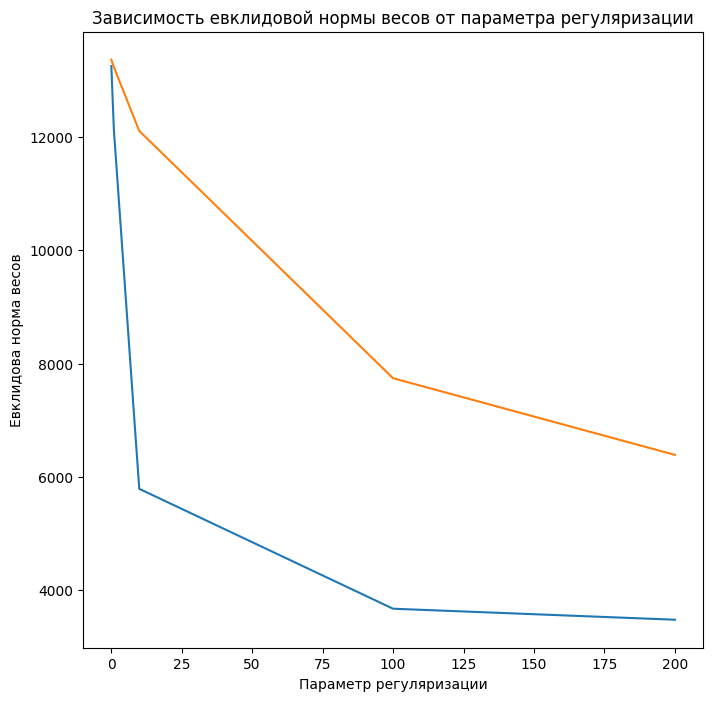

In [80]:
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.lineplot(x = parameters, y = lasso_norm)
sns.lineplot(x = parameters, y = ridge_norm)
plt.xlabel('Параметр регуляризации')
plt.ylabel('Евклидова норма весов')
plt.title('Зависимость евклидовой нормы весов от параметра регуляризации');

__Вывод:__ Агрессивнее уменьшает веса Lasso регуляризатор.
Чаще всего используют Lasso, потому что он зануляет многие признаки, тем самым уменьшая их количество и оставляя только те их них, которые значимо влияют на целевую переменную

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [81]:
from sklearn.linear_model import LassoCV

In [82]:
reg = LassoCV(alphas = parameters, cv=5, random_state=0).fit(X_train, y_train)
print(reg.mse_path_)
print(reg.alphas_)

[[2535143.21596209 2477942.97457696 2340250.79898885 2340635.19481961
  2594403.52665785]
 [2333185.8621746  2286172.39883319 2135331.54409772 2144193.32700004
  2377535.70489671]
 [1598926.5961357  1616283.57563492 1428384.52270304 1430277.1352915
  1618327.12283051]
 [1337110.13069155 1383760.70273584 1202357.38481848 1241749.02984804
  1371550.7614418 ]
 [1328760.85547694 1375500.80742968 1196734.43529397 1245980.33823902
  1378795.96753711]]
[2.e+02 1.e+02 1.e+01 1.e+00 1.e-01]


In [88]:
#Значение, которое дает наибольшее качество
mn = reg.alphas_[reg.mse_path_.mean(axis = 1).argmin()]
mn

0.1

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [91]:
lasso = Lasso(mn).fit(X_train, y_train)
print(*list(zip(lasso.coef_, X_train.columns)), sep = '\n')

(5254.523506893684, 'carat')
(-88.5754120780023, 'depth')
(-53.83534905061249, 'table')
(-1122.1688055810068, 'x')
(84.02594796678407, 'y')
(-41.13059181198339, 'z')
(577.5170172544325, 'cut_Good')
(822.3122197874656, 'cut_Ideal')
(751.0256947560349, 'cut_Premium')
(718.3931069483401, 'cut_Very Good')
(-211.03104593919593, 'color_E')
(-281.9065221216354, 'color_F')
(-483.0262437785741, 'color_G')
(-969.9438569636354, 'color_H')
(-1466.4691352647123, 'color_I')
(-2370.7305363094424, 'color_J')
(5320.700803694351, 'clarity_IF')
(3611.866801623341, 'clarity_SI1')
(2662.1446232241997, 'clarity_SI2')
(4526.304367568405, 'clarity_VS1')
(4220.070253686534, 'clarity_VS2')
(4974.401992162909, 'clarity_VVS1')
(4915.943304449768, 'clarity_VVS2')


__Вывод:__ При данном параметре регуляризации ни один из параметров не обнулился, в целом влияние регуляризации при данном параметре очень низкое, но так как параметр выбирался с целью минимизации ошибки,это говорит о том, что для целей минимизации ошибки лассо-регуляризация не дает сильного эффекта. Также раз ни один из параметром не занулился и в целом оценки не сильно изменились, все из признаков имеют значимое влияние.

Если обратить внимание на пункт задания, где проводилась лассо регуляризация при параметре 10 - там было зануление многих признаков. Такая регулиразция привела к увеличению ошибки, так как при кросс-валидации этот параметр не был выбран как наилучший

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [92]:
#Ошибка обученной Lasso-регрессии
y_pred = lasso.predict(X_test)
print(mean_squared_error(y_test, y_pred))

1225639.466111239


In [95]:
#Ошибка из задачи 3.7
print(f"Test: {mean_squared_error(y_test, y_test_pred)}")

Test: 1225819.1460399255


__Вывод:__ Модель с Лассо-регрессией оказалась лучше - она дает меньшую среднеквадратическую ошибку. Причина: лассо-регуляризация предотвратила переобучение модели, уменьшила мультиколлинеарность и влияние переменной, сильно превосходившей по модуля другие вещественные переменные.
Итог: лучше использовать модель с лассо-регрессией, однако разница в изначальной и новой модели невелико.